# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Задача:**
Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
#Загрузка библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import spacy

from pymystem3 import Mystem

from sklearn.utils import shuffle, resample


from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier


In [ ]:
#Загрузка данных
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    try:
        data  = pd.read_csv('/datasets/toxic_comments.csv')
    except:
        print('Ошибка. Проверьте путь к файлу')
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [ ]:
#Основная информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Количество строк - 159 292, данных достаточно для анализа.

Пропуски отсутствуют.

Для построение моделей необходимо лемматизировать содержание столбца 'text' - привести слова к их начальной форме, а также очистить от посторонних знаков.

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#Функция лемматизации и очистки текста
def spacy_lemm(row):
    doc = nlp(row.lower())  
    lemma = ' '.join([token.lemma_ for token in doc])
    lemma = ''.join(re.sub(r'[^A-Za-z]',' ',lemma))
    lemma = " ".join(lemma.split())
    return lemma

#Добавление столбца с лемматизированным и очищенным текстом
data['lemm']=data['text'].apply(spacy_lemm)

data.head(10)

,Unnamed: 0,text,toxic,lemm
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I be see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more I can not make any real suggestion on imp...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
5,5,"""\n\nCongratulations from me as well, use the ...",0,congratulation from I as well use the tool wel...
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense be offensive to you...
9,9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


Посмотрим на баланс классов в столбце 'toxic'.

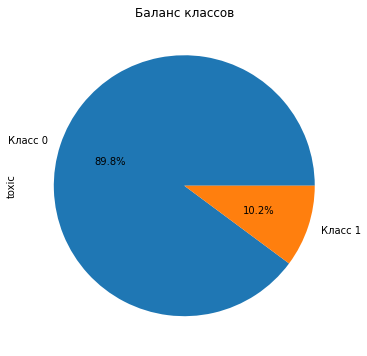

In [ ]:
#Проверка дисбаланса классов
data['toxic'].value_counts(normalize=True).plot(
    kind='pie',
    figsize=[6,6], 
    legend=False, 
    autopct='%1.1f%%',
    labels=['Класс 0','Класс 1'])

plt.title('Баланс классов')
plt.show()

Видно, что Класс 0 (не токсичный текст) существенно превышает Класс 1 (токсичный текст). Такой дисбаланс негативно скажется на результатах работы моделей.

In [ ]:
#Выделим признаки и целевую переменную
target = data['toxic']
features = data['lemm']

In [ ]:
#Разделим данные на обучающую, валидационную и тестовую выборки.
features_train, features_temp, target_train, target_temp = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.4, 
                                                                            random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(features_temp, 
                                                                            target_temp, 
                                                                            test_size=0.5,
                                                                            random_state=12345)

In [ ]:
#Загрузим стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Создание матрицы TF-IDF
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

features_train = count_tf_idf.fit_transform(features_train)
features_valid = count_tf_idf.transform(features_valid)
features_test = count_tf_idf.transform(features_test)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95575, 112667)
(31858, 112667)
(31859, 112667)


In [ ]:
#Построение модели LogisticRegression
CV = 3
model_LR = LogisticRegression()
train_LR_f1 = cross_val_score(model_LR, 
                           features_train, 
                           target_train, 
                           cv=CV, 
                           scoring='f1').mean()
print('F1 на обучающей выборке', train_LR_f1)

F1 на обучающей выборке 0.6938059632043053


Результат F1 ниже порогового значения из задания.

Для борьбы с дисбалансом классов попробуем применить уменьшение значений класса 0.

In [ ]:
data_train = data.iloc[target_train.index]

target_train_zero = data_train[data_train['toxic'] == 0]['toxic']
target_train_one = data_train[data_train['toxic'] == 1]['toxic']

target_train_zero_downsample = target_train_zero.sample(target_train_one.shape[0],
                                                        random_state=12345)

target_train_downsample = pd.concat([target_train_zero_downsample, target_train_one])


features_train_downsample = data.iloc[target_train_downsample.index]

#Перемешивание
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
#Создание матрицы TF-IDF
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm'])

#Проверка
print('До')
print(target_train.value_counts())
print('-'*40)
print('После')
print(target_train_downsample.value_counts())

До
0    85923
1     9652
Name: toxic, dtype: int64
----------------------------------------
После
0    9652
1    9652
Name: toxic, dtype: int64


Количество примеров Класса 0 теперь равно количеству Класса 1. 

In [ ]:
#Построение модели LogisticRegression с уменьшенной выборкой
model_LR = LogisticRegression()
train_LR_f1_dw = cross_val_score(model_LR,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=CV, 
                      scoring='f1').mean()
print('F1 на обучающей выборке сбалансированной', train_LR_f1_dw)

In [ ]:
#Результаты модели LogisticRegression
result_tab = pd.DataFrame(
    index=['LogisticRegression'])
result_tab['F1 original train data'] = train_LR_f1
result_tab['F1 downsampled train data'] = train_LR_f1_dw
result_tab

Результат модели существенно улучшился. Для обучения моделей целесообразно использовать сбалансированную выборку.

## Обучение

**LogisticRegression**

In [ ]:
model_LR = LogisticRegression()

model_LR_param = {'solver':['newton-cg', 'lbfgs', 'liblinear'],
                   'C':[0.1, 1, 10]}

model_LR_grid = GridSearchCV(model_LR, model_LR_param, scoring='f1', cv=CV)
model_LR_grid.fit(features_train_downsample, target_train_downsample)

model_LR_best_params = model_LR_grid.best_params_

result_train_LR = model_LR_grid.best_score_
print("Лучшие параметры:", model_LR_best_params)
print("F1 обучающей выборки:", result_train_LR)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшие параметры: {'C': 10, 'solver': 'newton-cg'}
F1 обучающей выборки: 0.8877186123430666


In [ ]:
model_LR = LogisticRegression()
model_LR.set_params(**model_LR_best_params)
model_LR.fit(features_train, target_train)
target_predict = model_LR.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', result_train_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.8877186123430666
F1 на валидации 0.7770722498712889


**DecisionTreeClassifier**

In [ ]:
model_DTC = DecisionTreeClassifier()
model_DTC_param = {'max_depth': range(1, 15, 2),
                   'min_samples_leaf': range(1,5),
                   'min_samples_split': range(2,8,2)}


model_DTC_grid = GridSearchCV(model_DTC, model_DTC_param, scoring='f1', cv=CV)
model_DTC_grid.fit(features_train_downsample, target_train_downsample)

model_DTC_best_params = model_DTC_grid.best_params_

result_train_DTC = model_DTC_grid.best_score_
print("Лучшие параметры:", model_DTC_best_params)
print("F1 на валидации:", result_train_DTC)

In [ ]:
model_DTC = DecisionTreeClassifier()
model_DTC.set_params(**model_DTC_best_params)
model_DTC.fit(features_train, target_train)
target_predict = model_DTC.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', result_train_DTC)
print('F1 на валидации', valid_f1_DTC)

**CatBoostClassifier**

In [ ]:
model_CAT = CatBoostClassifier(verbose=False, iterations=200)
model_CAT.fit(features_train_downsample, target_train_downsample)
target_predict = model_CAT.predict(features_valid)
CV_f1_CAT = cross_val_score(model_CAT,
                            features_train, 
                            target_train, 
                            cv=CV, 
                            scoring='f1').mean()

valid_f1_CAT = f1_score(target_valid, target_predict)
print('F1 на cv', CV_f1_CAT)
print('F1 на валидации', valid_f1_CAT)

## Выводы

In [ ]:
#Результаты моделей
result_tab = pd.DataFrame(
    index=['LogisticRegression',
           'DecisionTreeClassifier',
           'CatBoostClassifier'])
result_tab['F1 CV'] = result_train_LR, result_train_DTC, result_train_CAT
result_tab['F1 Validation'] = valid_f1_LR, valid_f1_DTC, valid_f1_CAT
result_tab

In [ ]:
#Результаты модели LogisticRegression на тестовой выборке
test_predict = model_LR.predict(features_test)
test_f1_LR = f1_score(target_test, test_predict)
print('F1 на Test', result_train_LR)

F1 на Test 0.8877186123430666


Построение ROC-кривой

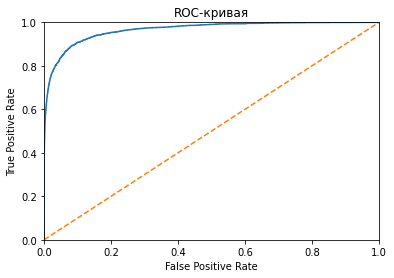

In [ ]:
probabilities_valid = model_LR.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)

#Случайная кривая
plt.plot([0, 1], [0, 1], linestyle='--')

#Установка границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#Подписи осей "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Заголовок 
plt.title('ROC-кривая')

plt.show()

**Вывод**

В рамках выполнения проекта было сделано:

- Произведена загрузка данных,их подготовка для обучения моделей.
- Скорректирован дисбаланс классов, данные поделены на обучающую, валидационную и тестовою выборки.
- Обучены модели, подобраны опртимальные гиперпараметры.
